In [33]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from ftplib import FTP
import os
sns.set()

%matplotlib inline

In [34]:
# Define the path where all the primary data are
datapath = "../../../Paper/Data"

# Download the PPI files from DroID

In [35]:
# Here you can change the version of the DroID PPI we use in the analysis
# For the paper, we use the 2017_08 version
# Uncomment the block for the version you want to use and comment the other ones

# PPI_ID = "2015_12"
# Annotation_ID = "2015_03" 

PPI_ID = "2017_08"
Annotation_ID = "2017_06" 

# PPI_ID = "2018_08"
# Annotation_ID = "2018_06" 

In [36]:
# Defining a helper function to go on a web database and download the corresponding file defined as url 
# The file is then saved into datapath

def download_and_save(url, datapath):
    # Recover the filename
    filename = url.split('/')[-1]
    # Logging out
    print("Downloading and saving ", filename)
    # Get a Web handle to the file on the server
    handle = requests.get(url)
    # Download the content 
    content = handle.content
    # Decode the content from bytes to String
    content = content.decode(errors='ignore') # error=ignore is here because the 2017 version has UTF-8 errors 
    # Create the path to save the data into using the datapath defined above
    savepath = os.path.join(datapath,"PPIs")
    # Making the directory if it does not exist
    if not os.path.isdir(savepath):
        os.mkdir(savepath)
    # Open and save the file
    file = open(os.path.join(savepath, filename), 'w')
    file.write(content)
    file.close()

In [37]:
# Here we define all the PPI files from the DROID we want to download.
# Because we only use a subset of the database containing PPI information

PPIs = ["http://www.droidb.org/data/DroID_v{}/finley_yth.txt".format(PPI_ID),
       "http://www.droidb.org/data/DroID_v{}/curagen_yth.txt".format(PPI_ID),
       "http://www.droidb.org/data/DroID_v{}/hybrigenics_yth.txt".format(PPI_ID),
       "http://www.droidb.org/data/DroID_v{}/perrimon_coapcomplex.txt".format(PPI_ID),
       "http://www.droidb.org/data/DroID_v{}/dpim_coapcomplex.txt".format(PPI_ID),
       "http://www.droidb.org/data/DroID_v{}/fly_other_physical.txt".format(PPI_ID),
       "http://www.droidb.org/data/DroID_v{}/flybase_ppi.txt".format(PPI_ID)]

In [38]:
# Loop over the list above and download the files.

for ppi in PPIs:
    download_and_save(ppi, datapath)

# Loading annotations from flybase to map Flybase ID to gene name

In [39]:
# Define the file name of the annotation file base on the annotation_ID 

filename = "fbgn_annotation_ID_fb_{}.tsv.gz".format(Annotation_ID)

In [40]:
# Connect to the FTP from flybase and download the annotation file

# define URL to ftp of flybase
flybaseftp = "ftp.flybase.net"
# Define the URL path
filepath = "releases/FB{}/precomputed_files/genes/fbgn_annotation_ID_fb_{}.tsv.gz".format(Annotation_ID, Annotation_ID)

# Establish connection to the FTP
ftp = FTP(flybaseftp)
ftp.login('','')

# Download the file
ftp.retrbinary("RETR {}".format(filepath) ,open(os.path.join(datapath, filename), 'wb').write)

# Close the connection
ftp.close()

In [41]:
# Load the annotation into a pandas dataframe
annotation = pd.read_table(os.path.join(datapath, filename),
                           compression='gzip',
                           skiprows=4,
                           keep_default_na=False)

In [42]:
# We want to create a dictionary that stores the FbID to gene name

# Define our dictionarry and call it mapping
mapping = {}
# Iterate over hte annotation
for i in range(len(annotation)):
        # Recover the FbID
        primary_FBgn = annotation['primary_FBgn#'][i]
        # Recover the gene name
        gene = annotation['##gene_symbol'][i]
        # Save the link into the dictionary
        mapping[primary_FBgn] = gene
        # That's important
        # If the gene has secondary FbID !! Then we need to grab thoose too as some genes will use this older ID
        # Instead of the newer one
        s = annotation['secondary_FBgn#(s)'][i]
        # If it exist
        if type(s) == str:
            # Recover all IDs
            s = s.split(',')
            # Iterate over the FbID
            for x in s:
                # Save the relationship in the mapping table
                mapping[x] = gene
# mapping

# Loading all the PPIs downloaded above 

In [43]:
# Define the path where we saved our PPIs previously
ppipath = os.path.join(datapath, "PPIs")

In [44]:
# Read every single PPI files into Pandas dataframe

flybasePPI = pd.read_table(os.path.join(ppipath,'flybase_ppi.txt'))
yeastPPI = pd.read_table(os.path.join(ppipath,'curagen_yth.txt'))
finleyPPI = pd.read_table(os.path.join(ppipath,'finley_yth.txt'))
hybriPPI = pd.read_table(os.path.join(ppipath,'hybrigenics_yth.txt'))
perimonPPI = pd.read_table(os.path.join(ppipath,'perrimon_coapcomplex.txt'))
DPIMPPI = pd.read_table(os.path.join(ppipath,'dpim_coapcomplex.txt'))
otherPPI = pd.read_table(os.path.join(ppipath,'fly_other_physical.txt'))

# Creating the concatenated PPI

In [45]:
# Create the graph to hold the network
G = nx.Graph()

In [46]:
# Define a function to add the node and edges in the network only if they don't already exist

def AddSet(G, db, id1, id2):
    # db here is a pandas edge list table
    # id1 and id2 are the column names of the node1 and node 2 of the edge list table
    # edge list table define network with each line as an interaction between gene1 and gene2
    
    # For each gene in the the first column 
    for gene in db[id1].unique():
        # If the gene is NOT in the network already
        if not G.has_node(gene):
            # Add the gene
            G.add_node(gene)
    # Same for the second column
    for gene in db[id2].unique():
        if not G.has_node(gene):
            G.add_node(gene)
    
    # Then we go through the edges 
    # For each line (aka each edge)
    for i in range(len(db)):
        # Grab the first and second gene
        gene1 = db[id1][i]
        gene2 = db[id2][i]
        # if the edge does not exist in the network
        if not G.has_edge(gene1,gene2):
            # AND IF the gene1 and gene2 are NOT the same gene
            # aka no self loop or self interaction !
            if gene1 != gene2:
                # We add the edge
                G.add_edge(gene1, gene2)
    # we return G
    return G

## Adding all the PPI dataset to the golbal PPI

In [47]:
# We define which table and column names to use
db = flybasePPI
id1 = 'FLY_GENE1'
id2 = 'FLY_GENE2'

# We add the node and edges from that file using the AddSet function defined above
G = AddSet(G, db,id1,id2)
# Now G holds the network information from the first file

# We do th same for all the files below

In [48]:
db = yeastPPI
id1 = 'FBGN_GENE1_BD'
id2 = 'FBGN_GENE2_AD'

# Here we pass G to the AddSet
G = AddSet(G, db,id1,id2)
# And recover it for the next
# Etc

In [49]:
db = finleyPPI
id1 = 'FBGN_GENE1_BD'
id2 = 'FBGN_GENE2_AD'

G = AddSet(G, db,id1,id2)

In [50]:
db = hybriPPI
id1 = 'FBGN_GENE1_BD'
id2 = 'FBGN_GENE2_AD'

G = AddSet(G, db,id1,id2)

In [51]:
db = perimonPPI
id1 = 'FBGN_BAIT'
id2 = 'FBGN_INTERACTOR'

G = AddSet(G, db,id1,id2)

In [52]:
db = DPIMPPI
id1 = 'FBGN_BAIT'
id2 = 'FBGN_INTERACTOR'

G = AddSet(G, db,id1,id2)

In [53]:
db = otherPPI
id1 = 'FLY_GENE1'
id2 = 'FLY_GENE2'

G = AddSet(G, db,id1,id2)

# Annotating Graph by adding gene names to the nodes

In [54]:
# the PPI is built with FbID but the gene names are useful to have
# So we are gonna use the annotation mapping we created above to give each node a name

# For each node in the PPI network G
for node in G.nodes():
    # If the node exist in the annotation 
    if node in mapping:
        # We define the label as the annotation name
        label = mapping[node]
    else:
        # Else we leave it to the FbID
        label = node
    # Save the annotation into the label tag in the node
    G.node[node]['label'] = label

# Saving Graph

In [55]:
# Using networkx to save as a GraphML
nx.write_graphml(G, os.path.join(datapath, 'PPI_{}.graphml'.format(PPI_ID)))

In [56]:
# and as an Edgelist (used by Diamond)
nx.write_edgelist(G, os.path.join(datapath, 'PPI_{}.edgelist'.format(PPI_ID)))

# Perform some Network Assement

In [57]:
# Read the PPI file to make sure the saving worked
G = nx.read_graphml(os.path.join(datapath, 'PPI_{}.graphml'.format(PPI_ID)))

In [58]:
# Calculating network density
# actual nb of Edges / total potential edges
n = len(G.nodes())
potential_edges = (n * (n-1))/2
density = len(G.edges()) / potential_edges
print("There are ", len(G.nodes()), 'nodes in the network')
print("There are ", len(G.edges()), 'edges in the network')
print("Network density is :", density)

There are  10633 nodes in the network
There are  80907 edges in the network
Network density is : 0.0014313482516098886


In [59]:
cc = nx.connected_components(G)
print([len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)])
largest_cc = max(nx.connected_components(G), key=len)

[10589, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]


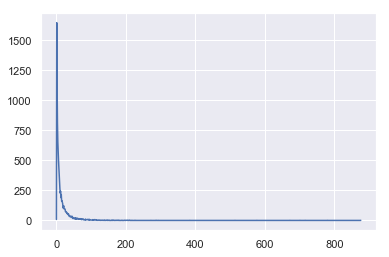

In [60]:
# Sanity Check that the network is Scale Free
degdist = nx.degree_histogram(G)
plt.plot(degdist)

Text(0.5, 1.0, 'LogLog plot of Degree Distribution')

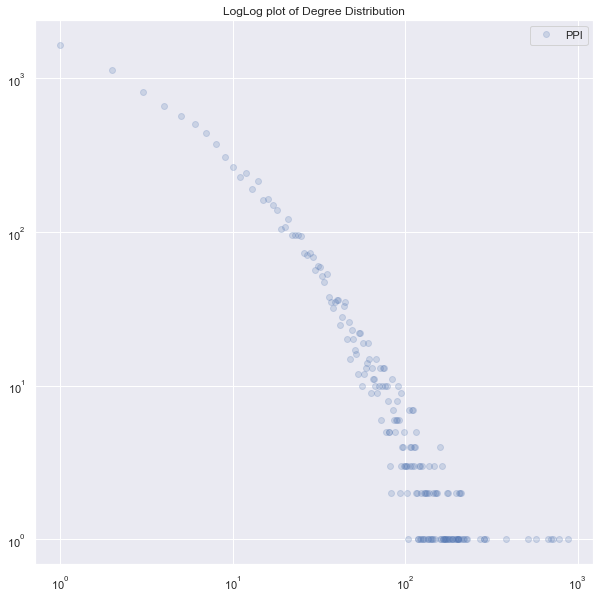

In [61]:
# Sanity Check that the network is Scale Free
# This should be a line, it's globally a line
fig = plt.figure(figsize=(10,10))
plt.loglog(degdist,'o', alpha=0.2, label='PPI')
plt.legend()
plt.title('LogLog plot of Degree Distribution')